<h1>Chapter01 程序与导函数<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# 有限差分之中的精度问题

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
def f(x):
    return x ** 0.5

def err(dx, x, fcn: Callable, fcn_prime:Callable):
    return (fcn(x+dx) - fcn(x)) / dx - fcn_prime(x)

In [3]:
pow = 16
eps = np.logspace(-pow-1, -1, pow*3+1).tolist()

## 公式
- <font color=white size=4 face=雅黑>x轴：</font> 
$$log_{10}(eps)$$
- <font color=white size=4 face=雅黑>y轴：</font> 
$$log_{10}(|\frac{f(x_{0}+eps)-f(x_0)}{eps} - f^{'}(x_0)|)$$


# math库

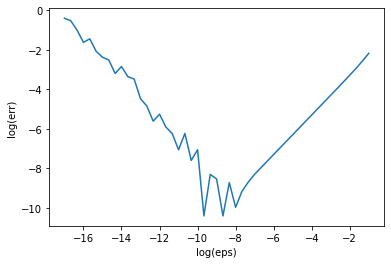

In [4]:
import math

x = 0.1
fcn = math.sin
fcn_prime = math.cos

err_math = []
eps_log_math = []
err_log_math = []
for e in eps:
    err_math.append(err(e, x, fcn, fcn_prime))
    err_log_math.append(math.log10(abs(err(e,x,fcn,fcn_prime))))
    eps_log_math.append(math.log10(e))

plt.xlabel("log(eps)")
plt.ylabel("log(err)")
plt.plot(eps_log_math, err_log_math)
plt.show()

## numpy库

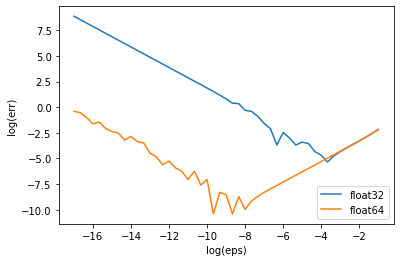

In [5]:
fcn = np.sin
fcn_prime = np.cos

eps_32_numpy = np.logspace(-pow-1, -1, pow*3+1, dtype=np.float32)
err_32_numpy = err(eps_32_numpy,x,fcn,fcn_prime)
eps_32_log_numpy = np.log10(eps_32_numpy)
err_32_log_numpy = np.log10(np.abs(err_32_numpy))

eps_64_numpy = np.logspace(-pow-1, -1, pow*3+1, dtype=np.float64)
err_64_numpy = err(eps_64_numpy,x,fcn,fcn_prime)
eps_64_log_numpy = np.log10(eps_64_numpy)
err_64_log_numpy = np.log10(np.abs(err_64_numpy))

plt.plot(eps_32_log_numpy, err_32_log_numpy, label = "float32")
plt.plot(eps_64_log_numpy, err_64_log_numpy, label = "float64")
plt.xlabel("log(eps)")
plt.ylabel("log(err)")
plt.legend(loc = "lower right")
plt.show()


# jax 库

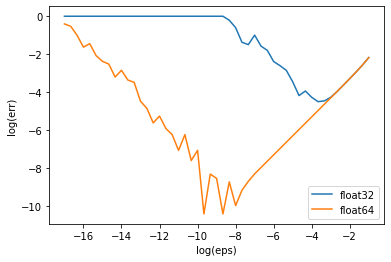

In [6]:
import jax.numpy as jnp
from jax.config import config

fcn = jnp.sin
fcn_prime = jnp.cos

config.update("jax_enable_x64",False)
eps_32_jnp = jnp.logspace(-pow-1, -1, pow*3+1)
err_32_jnp = err(eps_32_jnp,x,fcn,fcn_prime)
eps_32_log_jnp = jnp.log10(eps_32_jnp)
err_32_log_jnp = jnp.log10(np.abs(err_32_jnp))

config.update("jax_enable_x64",True)
eps_64_jnp = jnp.logspace(-pow-1, -1, pow*3+1)
err_64_jnp = err(eps_64_numpy,x,fcn,fcn_prime)
eps_64_log_jnp = jnp.log10(eps_64_jnp)
err_64_log_jnp = jnp.log10(np.abs(err_64_jnp))

plt.plot(eps_32_log_jnp, err_32_log_jnp, label = "float32")
plt.plot(eps_64_log_jnp, err_64_log_jnp, label = "float64")
plt.xlabel("log(eps)")
plt.ylabel("log(err)")
plt.legend(loc = "lower right")
plt.show()

## 集中展示

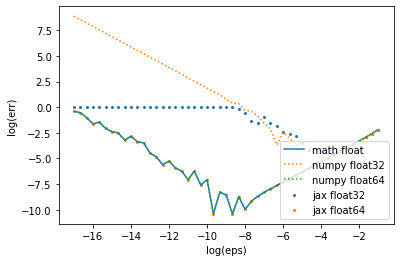

In [14]:
plt.plot(eps_log_math, err_log_math, label = "math float")
plt.plot(eps_32_log_numpy, err_32_log_numpy, label = "numpy float32", linestyle = ":")
plt.plot(eps_64_log_numpy, err_64_log_numpy, label = "numpy float64", linestyle = ":")
plt.scatter(eps_32_log_jnp, err_32_log_jnp, s = 4,  label = "jax float32")
plt.scatter(eps_64_log_jnp, err_64_log_jnp, s = 4, label = "jax float64")


plt.xlabel("log(eps)")
plt.ylabel("log(err)")
plt.legend(loc = "lower right")
plt.show()